In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

以下のセルでEKF_Simulation_AllData.csvにカラム名を付与してください

In [6]:
column_names = [
    'q1_s_est', 'q2_s_est', 'dq1_s_est', 'dq2_s_est',  # estSmall
    'q1_s_true', 'q2_s_true', 'dq1_s_true', 'dq2_s_true',  # s_StateHistory
    'u1_s', 'u2_s',  # s_uHistory
    'q1_l_est', 'q2_l_est', 'dq1_l_est', 'dq2_l_est',  # estLarge
    'q1_l_true', 'q2_l_true', 'dq1_l_true', 'dq2_l_true',  # l_StateHistory
    'u1_l', 'u2_l'  # l_uHistory
]
df = pd.read_csv("data\EKF_Simulation_AllData.csv", names=column_names, header=None)

In [17]:
df.to_csv("data\EKF_Simulation_AllData.csv",index=False)

次に「use_makecop.m」を実行してcopを計算してください
次にdata\EKF_Simulation_AllData_with_COP.csvを使用してcomのデータを取得します

In [56]:
df = pd.read_csv("data\EKF_Simulation_AllData_with_COP.csv")

system_params = {
    'm1': 25.00,   # Mass of the first segment (leg)
    'm2': 50.00,   # Mass of the second segment (trunk)
    'L1': 0.90,    # Length of the first segment (leg)
    'L2': 0.85,    # Length of the second segment (trunk)
    'com1': 0.45,  # Distance to CoM of the first segment
    'com2': 0.42,  # Distance to CoM of the second segment
    'g': 9.81      # Gravitational acceleration
}

# Function to calculate CoM
def calculate_com(q1, q2, params):
    q1_rad = np.deg2rad(q1)  # Convert to radians
    q2_rad = np.deg2rad(q2)

    m1 = params['m1']
    m2 = params['m2']
    L1 = params['L1']
    L2 = params['L2']
    r1 = params['com1']
    r2 = params['com2']

    # Calculate CoM positions
    X_CoM = (m1 * r1 * np.sin(q1_rad) + m2 * (L1 * np.sin(q1_rad) + r2 * np.sin(q1_rad + q2_rad))) / (m1 + m2)
    Z_CoM = (m1 * r1 * np.cos(q1_rad) + m2 * (L1 * np.cos(q1_rad) + r2 * np.cos(q1_rad + q2_rad))) / (m1 + m2)

    # Ensure it returns a Pandas Series with correct length
    return pd.Series([X_CoM, Z_CoM], index=['com_x', 'com_z'])

df[['com_x_s', 'com_z_s']] = df.apply(lambda row: calculate_com(row['q1_s_true'],row['q2_s_true'], system_params), axis=1)
df[['com_x_l', 'com_z_l']] = df.apply(lambda row: calculate_com(row['q1_l_true'],row['q2_l_true'], system_params), axis=1)

df[['dcom_x_s', 'dcom_z_s']] = df[['com_x_s', 'com_z_s']].diff().fillna(0)
df[['dcom_x_l', 'dcom_z_l']] = df[['com_x_l', 'com_z_l']].diff().fillna(0)

df[['ddcom_x_s', 'ddcom_z_s']] = df[['dcom_x_s', 'dcom_z_s']].diff().fillna(0)
df[['ddcom_x_l', 'ddcom_z_l']] = df[['dcom_x_l', 'dcom_z_l']].diff().fillna(0)

df[['dCOP_s', 'dCOP_l']] = df[['COP_s', 'COP_l']].diff().fillna(0)
df[['ddCOP_s', 'ddCOP_l']] = df[['dCOP_s', 'dCOP_l']].diff().fillna(0)

In [59]:
df.to_csv("data\EKF_Simulation_AllData_COP_COM.csv",index = False)

Text(0, 0.5, 'u2(N.m)')

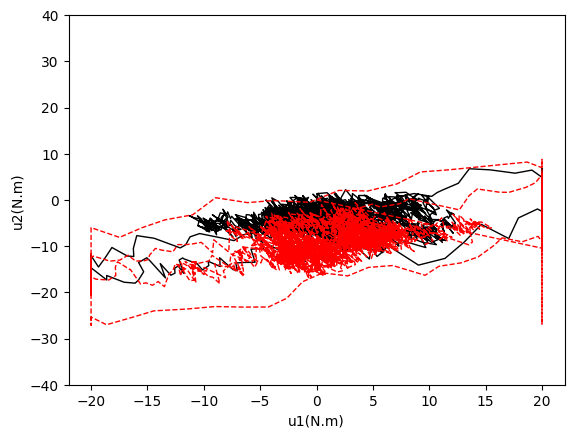

In [61]:
plt.plot(df['u1_s'], df['u2_s'], label='u1_s',color="black",linewidth=1)
plt.plot(df['u1_l'], df['u2_l'], label='u1_l',linestyle="--",color="r",linewidth=1)
plt.ylim(-40, 40)

plt.xlabel('u1(N.m)')
plt.ylabel('u2(N.m)')

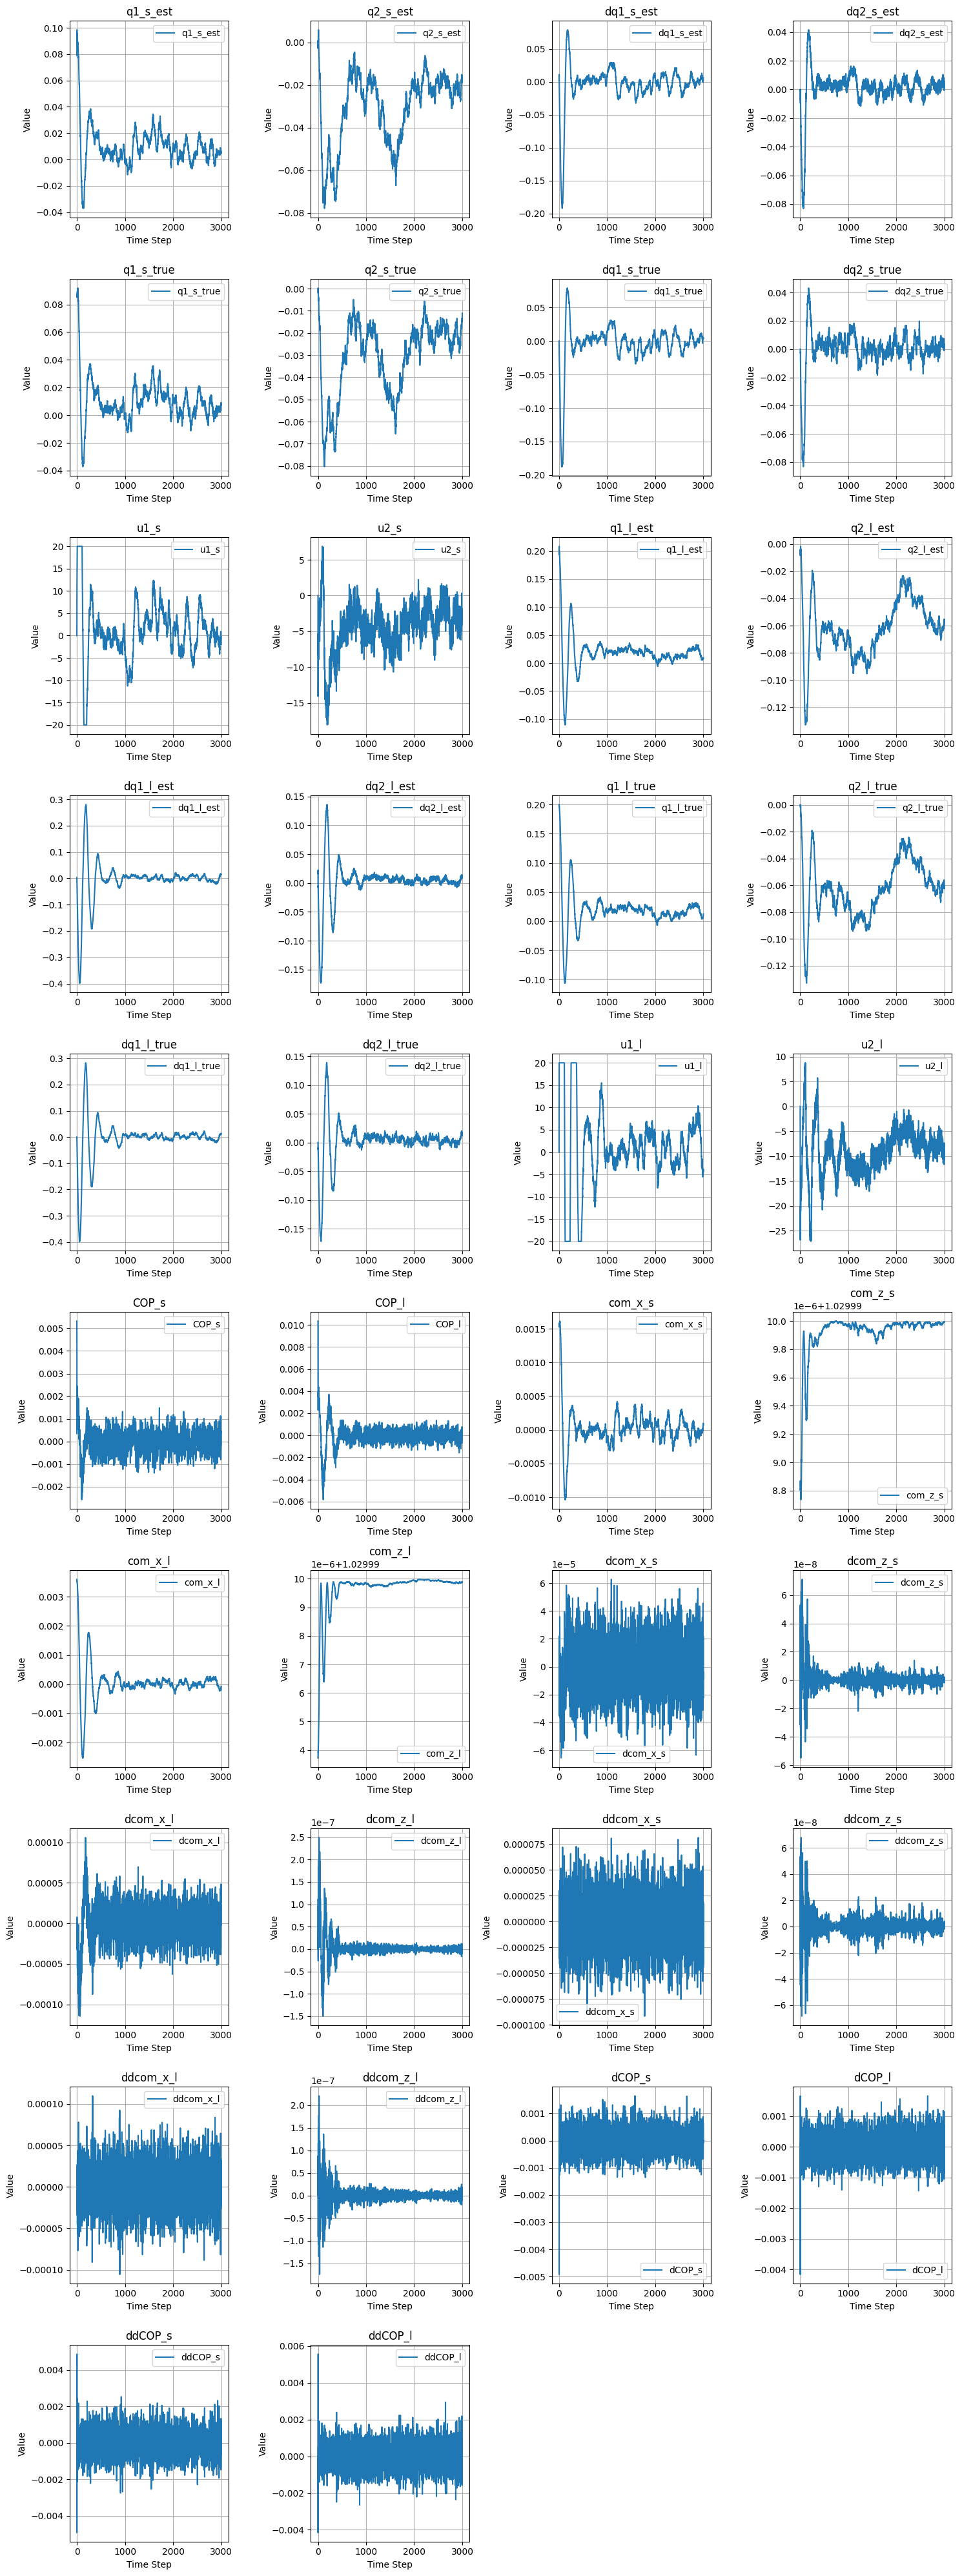

In [58]:
# データフレームのカラム数を取得
num_columns = len(df.columns)

# サブプロットのレイアウト設定（例: 4列）
num_rows = (num_columns // 4) + (num_columns % 4 > 0)  # 4列レイアウトの行数計算

# グラフのサイズ設定
plt.figure(figsize=(15, num_rows * 4))

# 各カラムをサブプロットとして描画
for i, column in enumerate(df.columns, 1):
    plt.subplot(num_rows, 4, i)  # 4列レイアウトでサブプロットを配置
    plt.plot(df[column], label=column)
    plt.title(column)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid()
    plt.legend()

# 全体のレイアウト調整
plt.tight_layout()
plt.show()